In [1]:
data_dir = '../../data/vehicles'
vehicles_dir = data_dir+'/vehicles'
non_vehicles_dir = data_dir+'/non-vehicles'

In [2]:
import glob
vehicles_files = glob.glob(vehicles_dir+'/**/*.png')
non_vehicles_files = glob.glob(non_vehicles_dir+'/**/*.png')
print("Vehicles: ", len(vehicles_files))
print("Non-vehicles: ", len(non_vehicles_files))

Vehicles:  8792
Non-vehicles:  8968


In [3]:
# Load them all (data is fairly small)
import cv2

vehicles = list(map(cv2.imread, vehicles_files))
non_vehicles = list(map(cv2.imread, non_vehicles_files))
print("Vehicles: ", len(vehicles))
print("Non-vehicles: ", len(non_vehicles))

Vehicles:  8792
Non-vehicles:  8968


In [4]:
# Do a train_test_split on each
from sklearn.model_selection import train_test_split
vehicles_train, vehicles_validation = train_test_split(vehicles, test_size=300)
non_vehicles_train, non_vehicles_validation = train_test_split(non_vehicles, test_size=300)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline

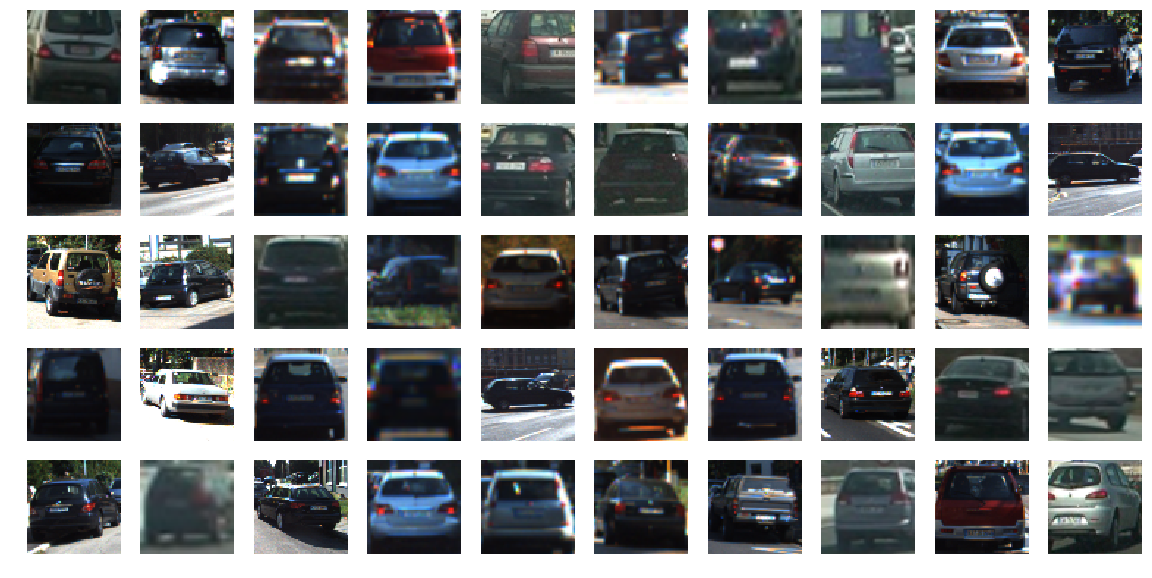

In [6]:
plt.figure(figsize=(20, 10))
for j in range(0, 50):
    plt.subplot(5, 10, j+1)
    plt.imshow(cv2.cvtColor(vehicles_train[j], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

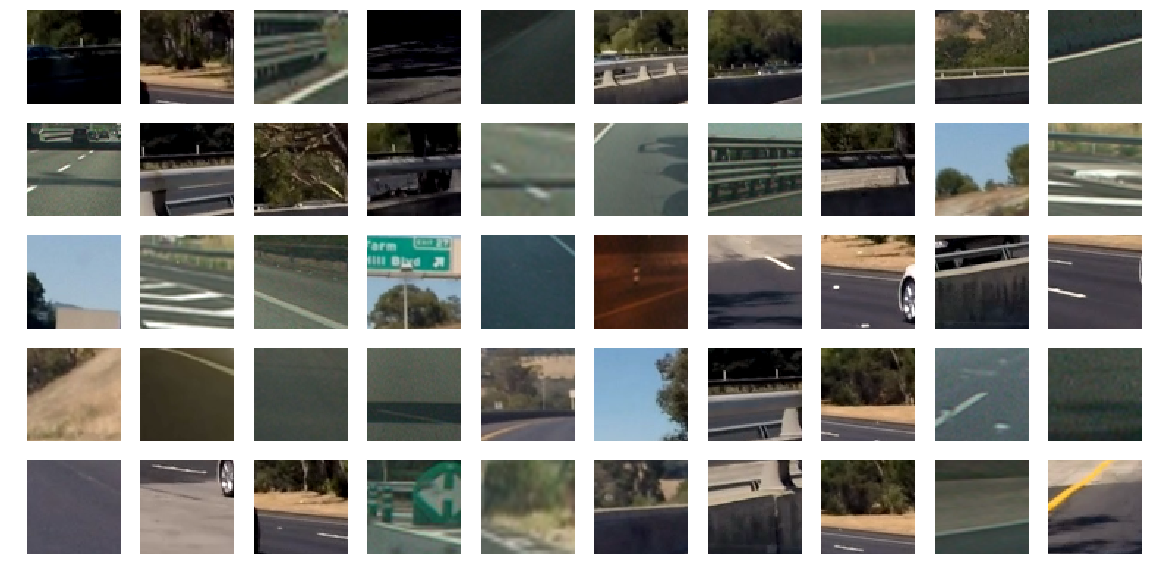

In [7]:
plt.figure(figsize=(20, 10))
for j in range(0, 50):
    plt.subplot(5, 10, j+1)
    plt.imshow(cv2.cvtColor(non_vehicles_train[j], cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

In [8]:
from sklearn.utils import shuffle
X_train = np.concatenate([vehicles_train, non_vehicles_train])
y_train = np.concatenate([np.repeat(1, len(vehicles_train)), np.repeat(0, len(non_vehicles_train))])
X_train, y_train = shuffle(X_train, y_train)
X_valid = np.array(vehicles_validation + non_vehicles_validation)
y_valid = np.concatenate([np.repeat(1, len(vehicles_validation)), np.repeat(0, len(non_vehicles_validation))])

In [9]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler

def prepare(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv)
    y_hog = hog(y, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    u_hog = hog(u, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    v_hog = hog(v, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    res = np.concatenate([y_hog, u_hog, v_hog])
    
    return res

In [10]:
X_train_reduced = np.zeros((X_train.shape[0],972))
for i in range(X_train.shape[0]):
    X_train_reduced[i] = prepare(X_train[i])

/home/tvh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(verbose=1)

clf.fit(X_train_reduced, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2434            3.17m
         2           1.1263            3.13m
         3           1.0265            3.09m
         4           0.9392            3.06m
         5           0.8639            3.03m
         6           0.8001            2.99m
         7           0.7430            2.96m
         8           0.6939            2.93m
         9           0.6495            2.90m
        10           0.6093            2.87m
        20           0.3634            2.56m
        30           0.2428            2.23m
        40           0.1769            1.91m
        50           0.1358            1.65m
        60           0.1087            1.33m
        70           0.0897           59.91s
        80           0.0756           39.93s
        90           0.0654           19.92s
       100           0.0575            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

In [12]:
X_valid_reduced = np.zeros((X_valid.shape[0],972))
for i in range(X_valid.shape[0]):
    X_valid_reduced[i] = prepare(X_valid[i])

/home/tvh/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [13]:
pred_train = clf.predict(X_train_reduced)

In [14]:
pred_valid = clf.predict(X_valid_reduced)

In [15]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, pred_train)
acc_valid = accuracy_score(y_valid, pred_valid)
print("Training accuracy: ", acc_train)
print("Validation accuracy: ", acc_valid)

Training accuracy:  0.996037296037
Validation accuracy:  0.985


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_train, pred_train))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      8668
          1       1.00      1.00      1.00      8492

avg / total       1.00      1.00      1.00     17160



In [17]:
print(classification_report(y_valid, pred_valid))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       300
          1       0.99      0.98      0.98       300

avg / total       0.99      0.98      0.98       600



In [18]:
from sklearn.externals import joblib

joblib.dump(clf, 'classifier.pkl')

['classifier.pkl']